# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
import sys, datetime

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir FIG 
!mkdir FIG/FRAME
!mkdir WEIGHTS 
!mkdir DATA

mkdir: cannot create directory ‘FIG’: File exists
mkdir: cannot create directory ‘FIG/FRAME’: File exists
mkdir: cannot create directory ‘WEIGHTS’: File exists
mkdir: cannot create directory ‘DATA’: File exists


## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X_original.shape)

(70000, 784)


## Parameters

In [29]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('0', '1', '2')
dataset with 21770 points, each with 784 bits

first 10 MNIST data points


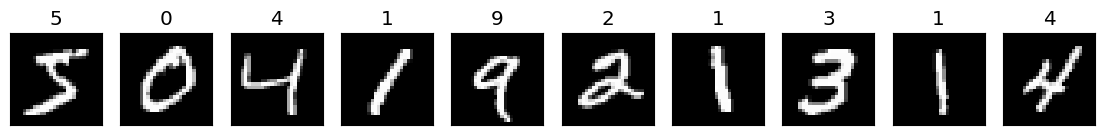

first 10 MNIST-3 data points


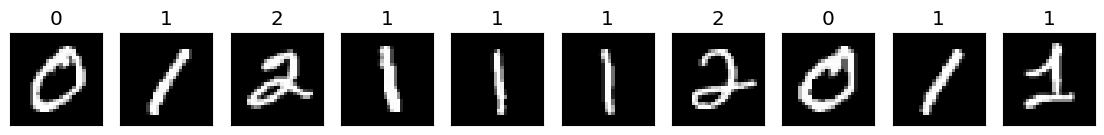

first 10 MNIST-3 data points, binarized


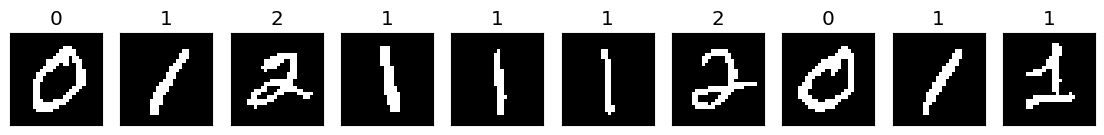

each of Nd=21770 data has D=784 bits


In [4]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "gray"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

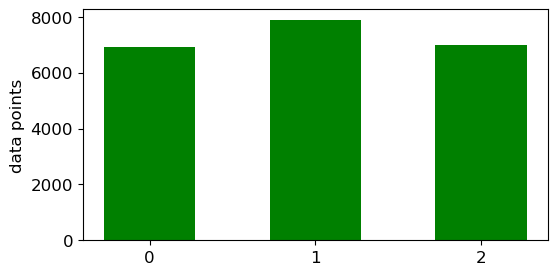

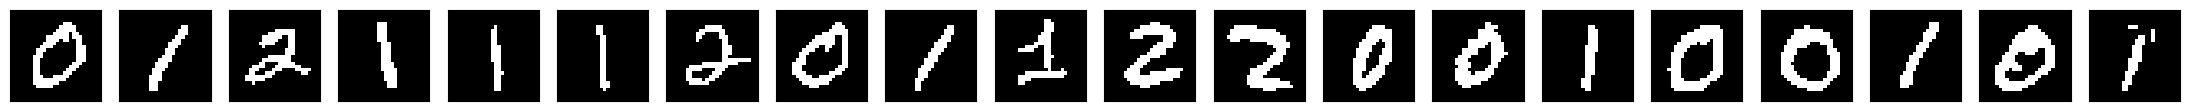

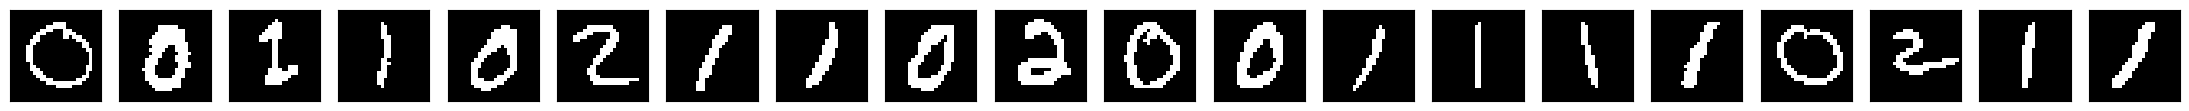

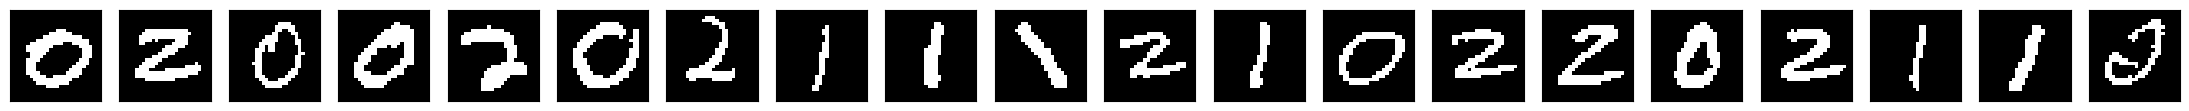

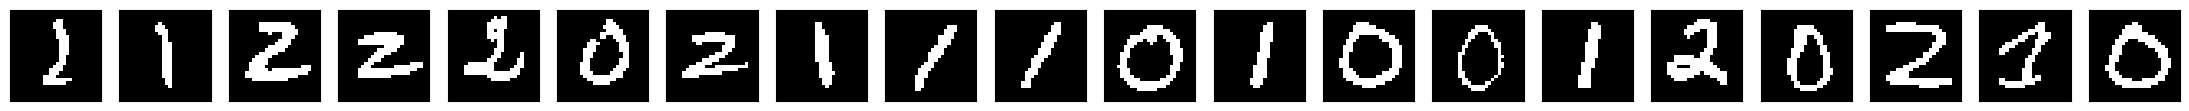

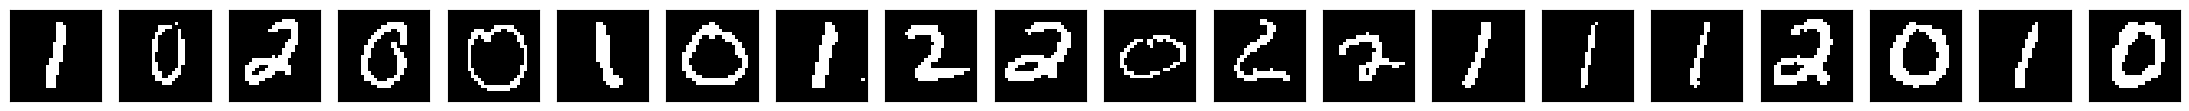

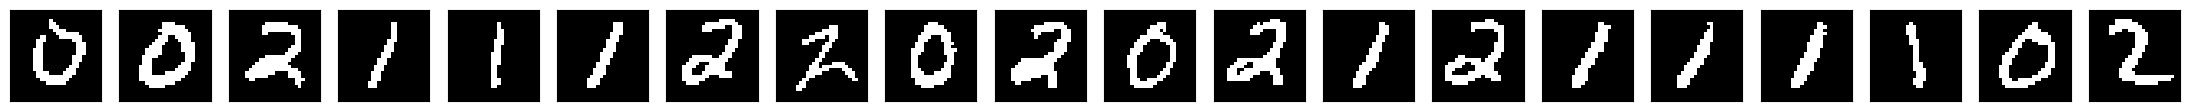

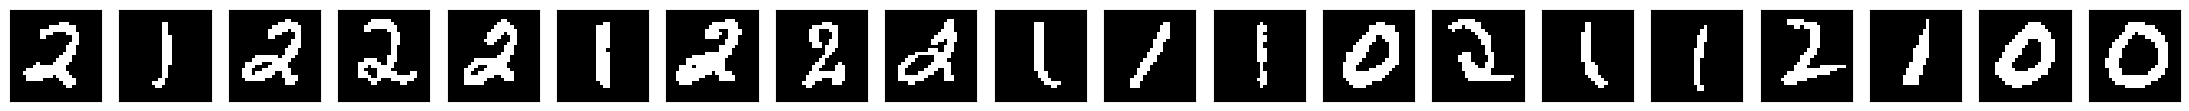

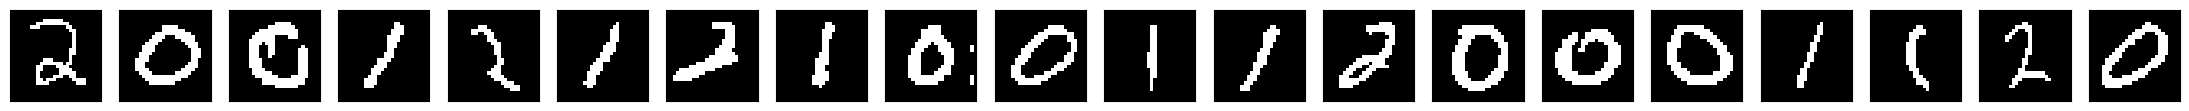

In [5]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [7]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [8]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [9]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


# RBM train


In [58]:
def RBM_train(steps,Nepoch,Nmini,plot):
    # random seed for reproducibility
    np.random.seed(12345)
    
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(D,L)
    #a = sigma * np.random.randn(D)
    # using Hinton initialization of visible biases
    a = Hinton_bias_init(data)
    # hidden biases initialized to zero
    b = np.zeros(L)
    #print("w=",w);print("a=",a);print("b=",b)
    
    # nr of epochs
    #Nepoch=25
    # minibatches per epoch
    #Nmini=20
    # minibatch size at initial epoch and final one
    N_ini,N_fin=10,500
    print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    # number of CD steps
    Nt=steps
    
    # recording history of weights ("E" means epoch)
    wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
    wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
    gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
    gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
    gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
    miniE = np.zeros(Nepoch+1)
    pzE=np.zeros((Nepoch+1,Nz))
    if GRAD=="RMSprop": 
        gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    
    indices=np.arange(Nd).astype("int")
    plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
    
    # for the plot with panels
    Ncols=min(8,max(2,L//2))
    
    if POTTS: print("Starting the training, POTTS=True")
    else: print("Starting the training")
    
    # Note: here an epoch does not analyze the whole dataset
    for epoch in range(1,1+Nepoch):
        # q maps epochs to interval [0,1]
        q = (epoch-1.)/(Nepoch-1.) 
        # N, size of the mini batch
        # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
        N = int(N_ini + (N_fin-N_ini)*(q**2))
        #  l_rate interpolates between initial and final value
        l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q
    
        for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
            
            # Minibatch of size N: points randomply picked (without repetition) from data
            selected = np.random.choice(indices,N,replace=False)
            if epoch==1 and mini<=3: print(selected)
            
            for k in range(N):
                ###################################
                x0 = data[selected[k]]
                # positive CD phase: generating z from x[k]
                z = CD_step(x0,w,b,POTTS=POTTS)
                x_data  += x0
                z_data  += z
                xz_data += np.outer(x0,z)
                # fantasy
                zf=np.copy(z)
                # Contrastive divergence with Nt steps
                for t in range(Nt):
                    # negative CD pzase: generating fantasy xf from fantasy zf
                    xf = CD_step(zf,w.T,a)
                    # positive CD phase: generating fantasy zf from fantasy xf 
                    zf = CD_step(xf,w,b,POTTS=POTTS)
                x_model += xf
                z_model += zf
                xz_model+= np.outer(xf,zf)
                # recording probability of encoding in z-space, if POTTS
                if POTTS: pz[zf]+=1
                ###################################
            
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)
    
            # gradient ascent step
            if GRAD=="RMSprop":
                # RMSprop gradient ascent
                gw2 = beta*gw2+(1-beta)*np.square(gw)
                ga2 = beta*ga2+(1-beta)*np.square(ga)
                gb2 = beta*gb2+(1-beta)*np.square(gb)
                w += l_rate*gw/sqrt(epsilon+gw2)
                a += l_rate*ga/sqrt(epsilon+ga2)
                b += l_rate*gb/sqrt(epsilon+gb2)
            else: 
                # defaulting to the vanilla stochastic gradient ascent (SGD)
                w += l_rate*gw
                a += l_rate*ga
                b += l_rate*gb
            # regularization (LASSO)
            if gamma>0.:
                w -= (gamma*l_rate)*sign(w)
                a -= (gamma*l_rate)*sign(a)
                b -= (gamma*l_rate)*sign(b)
    
        wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
        aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
        bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
        miniE[epoch]=N
        if POTTS: pzE[epoch] = pz/np.sum(pz)
        print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
              " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
        if plot:
            if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
                plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
                
        str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")
    
    print("END of learning phase")
    return wE, aE, bE

In [45]:
'''import numpy as np
import itertools

def compute_log_likelihood(data, w, a, b):
    """
    Computes the log-likelihood of the dataset given the current parameters.
    """
    L_samples = []
    
    # Iterate over all possible hidden states
    z_matrix = np.array(list(itertools.product([0, 1], repeat=L)))  # All 2^L configurations

    for x in data:
        z=CD_step(x,w,b,POTTS=POTTS)
        # Compute first term: sum over hidden states for given x
        exp_E_x_z = []
        H=[]
        exp_E_x_prime_z = []
        Z=0
        q_list=[]
        epsilon=1e-4
        for z in z_matrix:
            H_x_z = a + np.dot(w, z)
            E_x_z = np.sum(b * z) + np.sum(H_x_z * x)
            exp_E_x_z.append(np.exp(E_x_z))
            H_x_prime_z = a + np.dot(w, z)
            q=np.mean(1+np.exp(H_x_prime_z))
            q_list.append(np.mean(q))
            G_z = np.exp(np.sum(b * z))
            prod_term = np.prod((1 + np.exp(H_x_prime_z)) / q)
            #exp_E_x_prime_z.append(G_z * prod_term)
            Z +=G_z*prod_term
        Z=D*np.log(np.mean(q_list))+np.log(Z)
        log_sum_exp = np.log(np.sum(exp_E_x_z))
        log_likelihood = log_sum_exp - Z
        L_samples.append(log_likelihood)

    return np.mean(L_samples)  # Average over dataset


log_likelihood_values = np.zeros(Nepoch + 1)
for epoch in range(1,Nepoch+1):
    print(f'epoch: {epoch}')
    log_likelihood_values[epoch] = compute_log_likelihood(data, wE[epoch], aE[epoch], bE[epoch])


plt.figure(figsize=(8, 6))
plt.plot(np.arange(Nepoch + 1), log_likelihood_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood Evolution During Training')
plt.show()
''' #USELESS


epoch: 1


KeyboardInterrupt: 

Nepoch=25
Nmini=20


<Figure size 640x480 with 0 Axes>

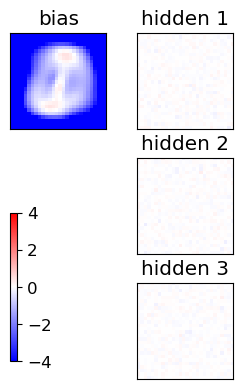

Starting the training
[12775  9990  2591 14746 12913    95 10946  3140  2405 11413]
[12108 19084  8445 11961 15494   499  8155  2251  1202 16962]
[19240 12893 17188 10475 16121 12081  8741 12005 21086 20044]
[18353 10714 18503 16075  9638 19466  2134 12377  9247 14851]
epoch 1 / 25  Nt: 1  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 25  Nt: 1  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 25  Nt: 1  N: 13  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 25  Nt: 1  N: 17  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 25  Nt: 1  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 25  Nt: 1  N: 31  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 25  Nt: 1  N: 40  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 25  Nt: 1  N: 51  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 25  Nt: 1  N: 64  L: 3  rate: 0.05  gam: 0.001 SPINS= Fa

<Figure size 640x480 with 0 Axes>

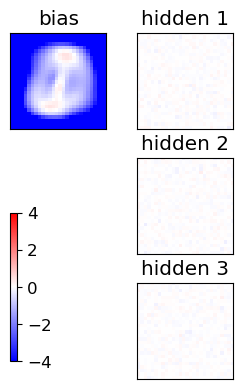

Starting the training
[12775  9990  2591 14746 12913    95 10946  3140  2405 11413]
[ 5236   215  6623 14977 17258  6734 10141 13492 14156  1545]
[10681 19445   202 13120  2435 20033 14706 16365  4852 18268]
[ 1401 14522 11148  1843    50  3640   936 15921  9033  5036]
epoch 1 / 25  Nt: 7  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 25  Nt: 7  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 25  Nt: 7  N: 13  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 25  Nt: 7  N: 17  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 25  Nt: 7  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 25  Nt: 7  N: 31  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 25  Nt: 7  N: 40  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 25  Nt: 7  N: 51  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 25  Nt: 7  N: 64  L: 3  rate: 0.05  gam: 0.001 SPINS= Fa

In [59]:
import itertools
import numpy as np

binary=True

def lkl(data, w, a, b, Nd, binary):

    
    z_matrix = np.array(list(itertools.product([0, 1], repeat=L))) #Set of all the possible configurations of the L hidden variables
    
    '''epsilon=1e-14
    q_values = []
    H_val1=[]
    for z,i in zip(z_matrix,range(len(z_matrix))): #Computes q as the average over i of 1+H_i
        H_val1.append(a + np.dot(w, z))
        q_values.append(np.mean(1 + np.exp(H_val1[i])))
    q = np.mean(q_values)  # Average over visible units''' #Using q as average of 1+H_i over i won't work because we'll get errors related to log(0) computation, and if we
    #try to cprrect them via computing log(0+epsilon) we get completely different results because that 0 is like 1e-320 so 1e-320 + epsilon is basically epsilon
    
    log_likelihood=0
    q=1
    for (x,j) in zip(data,range(len(data))):  #Iterate the likelihood computattion over all the images (of 0, 1, 2) of the mnist dataset 
        z_sum = 0.0
        energy = 0.0
        
        if binary:
            for z,i in zip(z_matrix,range(len(z_matrix))):
                H_val=a + np.dot(w, z)
                G_val = np.exp(np.dot(z, b))
                prod_term = np.prod((1 + np.exp(H_val)) / q)
                z_sum += G_val * prod_term
                energy += G_val * np.exp(np.dot(H_val, x)) # Energy term for the data point x  
            
            part_funct = Nd * np.log(q) + np.log(z_sum+epsilon)
            if(j==(len(data[-1]))):
                line=f"zsum={z_sum},log_zsum={np.log(z_sum)},part_funct={part_funct}\t energy={energy} \t log_energy={np.log(energy)}'\n'"
                file.write(line)
        else:
            # If using a different representation (e.g., spins), you would add a modified computation here.
            raise NotImplementedError("Non-binary case not implemented.")
            
        log_likelihood+=np.log(energy) - part_funct
        
    return log_likelihood/len(data) #compute the average likelihood of the images


with open("intermediate_calculations2.txt", "w") as file:
    pass  # This clears the content and closes the file
file = open("intermediate_calculations2.txt",'a') # Open the file in append mode to write lines
steps=[1,7]
lkl_list=[]

for step in steps:
    line = f'\n\nnew step: {step}\n'
    file.write(line)
    log_likelihood_values = np.zeros(Nepoch+1)
    wE, aE, bE, = RBM_train(step, Nepoch=25, Nmini=20, plot=False)
    for epoch in range(1, Nepoch + 1):  
        print(f'epoch: {epoch}')
        line = f'\n\nnew epoch: {epoch}\n'
        file.write(line)
        log_likelihood_values[epoch] = lkl(data, wE[epoch], aE[epoch], bE[epoch], D, binary)
    lkl_list.append(log_likelihood_values[1:])
    
file.close()

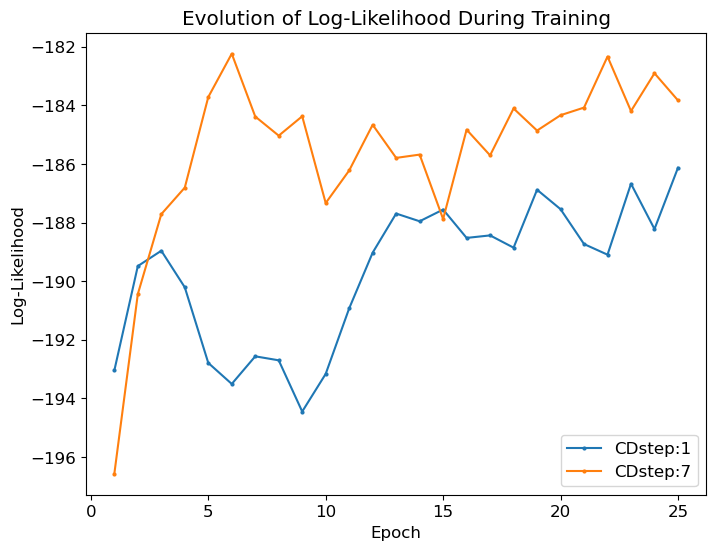

In [60]:
plot_lkl=True
if plot_lkl:
    fig, ax = plt.subplots(1,1,figsize=(8, 6))
    for i,step in enumerate(steps):
        ax.plot(np.arange(1,Nepoch+1), lkl_list[i], marker='o', markersize=2, linestyle='-', label=f'CDstep:{step}')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log-Likelihood')
    ax.set_title('Evolution of Log-Likelihood During Training')
    

## Test generative power of the trained RBM

<Figure size 640x480 with 0 Axes>

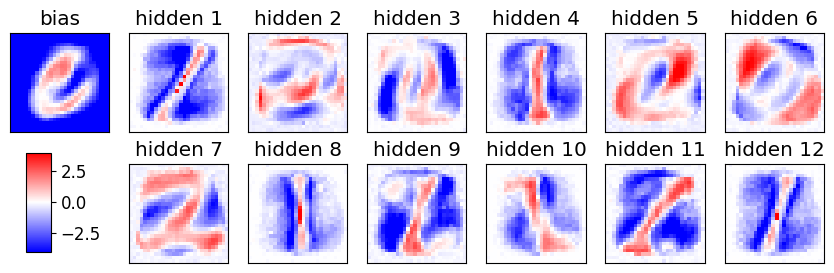

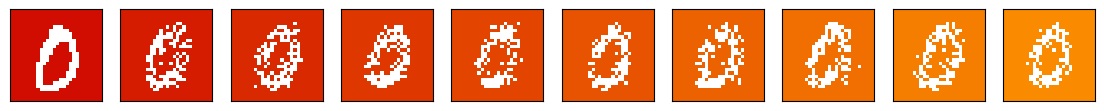

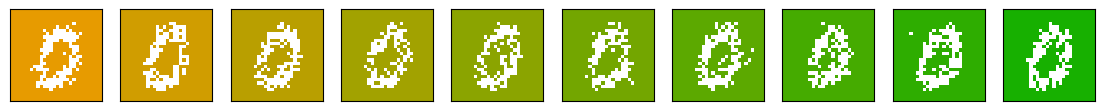

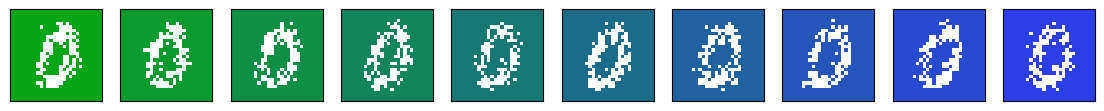

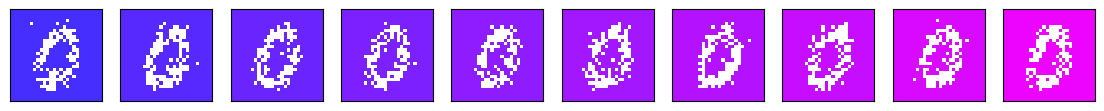

L: 12     amplification of weights: 1.0


In [22]:
ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

NE= 150


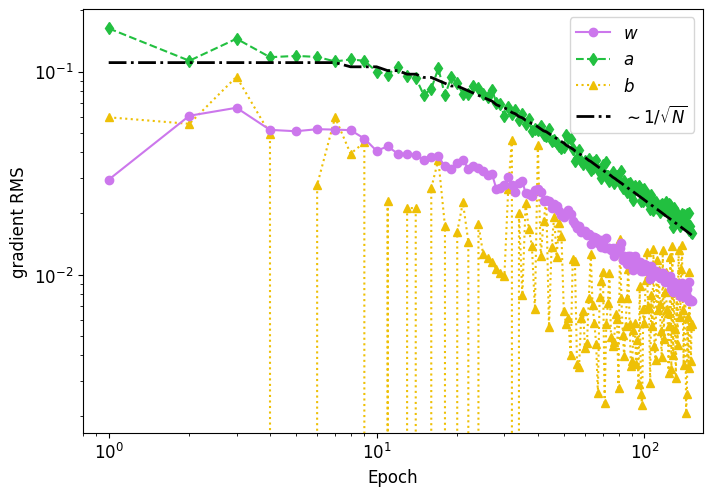

FIG/RBM_grad_MNIST3_E150_N10-500_RMSprop-0.05-0.05_CD-2_L12_reg0.001.png


In [16]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [15]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

WEIGHTS/w_RBM_MNIST3_L12_RMSprop-0.05-0.05_Ep150_reg0.001_20250303_0811.npy
WEIGHTS/b_RBM_MNIST3_L12_RMSprop-0.05-0.05_Ep150_reg0.001_20250303_0811.npy
WEIGHTS/a_RBM_MNIST3_L12_RMSprop-0.05-0.05_Ep150_reg0.001_20250303_0811.npy


In [19]:
Nd

21770